# Predict Remaining Useful Lifetime - Nasa Torbofan

## Pre-work
At first, we prepare training for automated machine learning and use [tsfresh](https://tsfresh.readthedocs.io/en/latest/) for time-series feature engineering.

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (19.2.3)


In [2]:
!pip install tsfresh

In [3]:
%matplotlib inline

import pandas as pd 

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
import datetime
pd.set_option('display.max_columns', 60)

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [5]:
train_df.head(10)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
5,1,6,0.252874,0.416667,0.0,0.0,0.268072,0.292784,0.272113,0.0,1.0,0.776167,0.181818,0.125415,0.0,0.184524,0.637527,0.220588,0.169832,0.330512,0.0,0.250000,0.0,0.0,0.651163,0.652720,186,0,0,0.013850
6,1,7,0.557471,0.583333,0.0,0.0,0.382530,0.463920,0.261985,0.0,1.0,0.723027,0.181818,0.167818,0.0,0.303571,0.773987,0.220588,0.167097,0.278953,0.0,0.333333,0.0,0.0,0.744186,0.667219,185,0,0,0.016620
7,1,8,0.304598,0.750000,0.0,0.0,0.406627,0.259865,0.316003,0.0,1.0,0.644122,0.151515,0.085569,0.0,0.232143,0.805970,0.220588,0.160646,0.318199,0.0,0.250000,0.0,0.0,0.643411,0.574979,184,0,0,0.019391
8,1,9,0.545977,0.583333,0.0,0.0,0.274096,0.434707,0.211850,0.0,1.0,0.618357,0.227273,0.110967,0.0,0.261905,0.660981,0.250000,0.132883,0.184302,0.0,0.333333,0.0,0.0,0.705426,0.707539,183,0,0,0.022161
9,1,10,0.310345,0.583333,0.0,0.0,0.150602,0.440375,0.307394,0.0,1.0,0.602254,0.227273,0.134479,0.0,0.107143,0.660981,0.264706,0.151925,0.399000,0.0,0.416667,0.0,0.0,0.627907,0.794256,182,0,0,0.024931


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

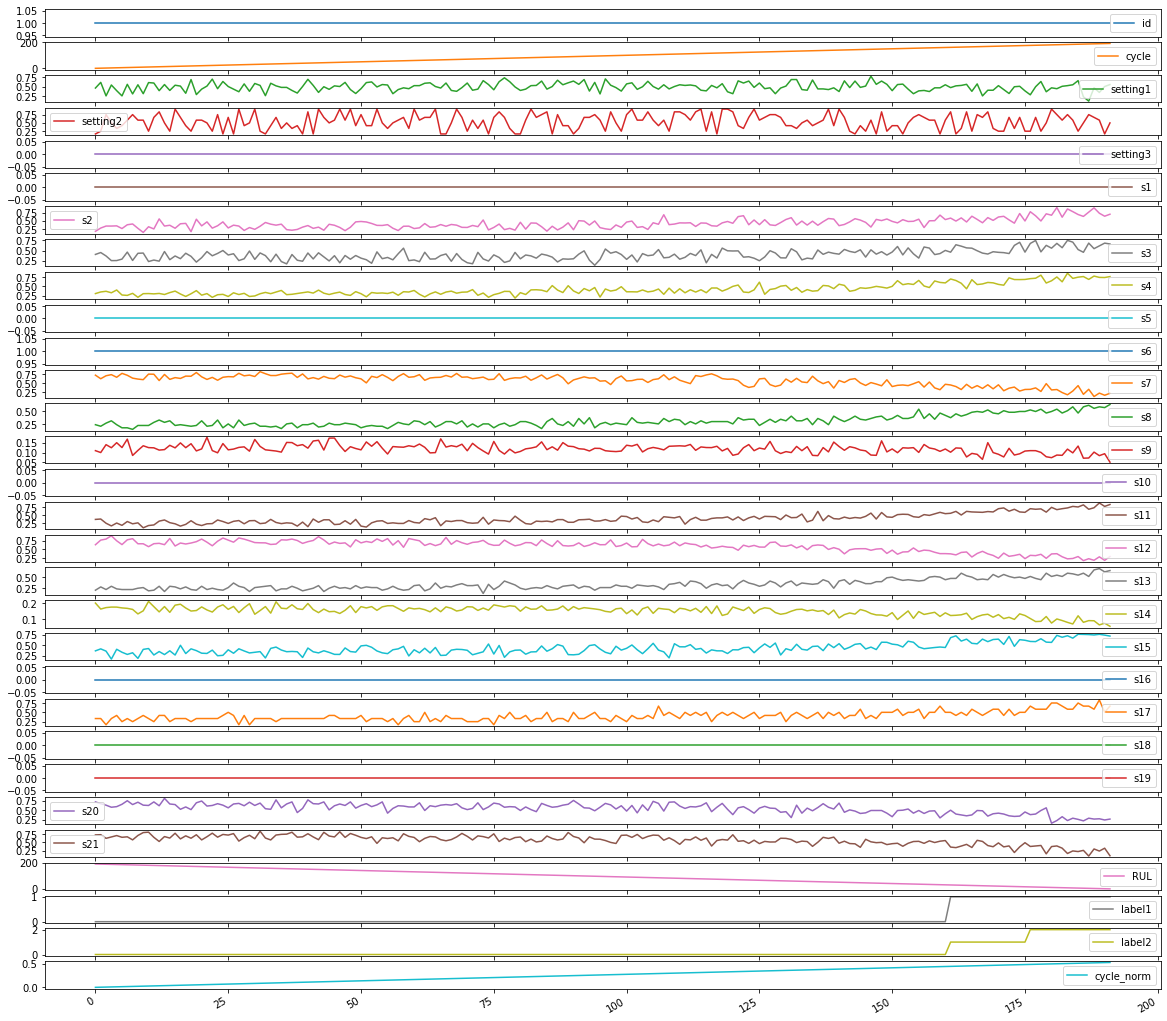

In [6]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()
train_df[train_df["id"]==1].plot(subplots=True, sharex=True, figsize=(20,20))
#plt.savefig(img_path+"turbine1-line.png")
plt.show()

In [7]:
#settings= MinimalFCParameters() # only a few basic features
#settings
# choose very basic features for quick demo.
settings_minimal = {'mean': None, 'maximum': None,'minimum': None}

In [8]:
# extract id list for train & test data
unit_list_train = train_df["id"].unique()
unit_list_test = test_df["id"].unique()

In [9]:
#　extract column name for feature
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle']
sequence_cols.extend(sensor_cols)

In [10]:
def create_feature_extract(unit_list, df):
    all_df = pd.DataFrame()
    for unit_id_num in unit_list:
        print("unit id is", unit_id_num)
        tmp = df[df['id']==unit_id_num]
        base_df = pd.DataFrame() 

        for col in sequence_cols:
            df_shift, y = make_forecasting_frame(tmp[col], kind=col, max_timeshift=5, rolling_direction=2)
            X = extract_features(df_shift, column_id="id", column_sort="time", column_kind="kind", column_value="value", impute_function=impute, show_warnings=False, default_fc_parameters = settings_minimal)
            #X = X.loc[:, X.apply(pd.Series.nunique) != 1] # remove unique columns
            base_df = pd.concat([base_df, X], axis=1)
        base_df["id"] = unit_id_num
        base_df["RUL"] = tmp["RUL"]
        all_df = all_df.append(base_df)
    return all_df

In [11]:
#train = create_feature_extract(unit_list_train[:20],train_df)
train = create_feature_extract(unit_list_train[:10],train_df)

unit id is 1


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 28708.45it/s]


unit id is 2


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 615.91it/s]


unit id is 3


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 10997.13it/s]


unit id is 4


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 6424.11it/s]


unit id is 5


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 4436.54it/s]


unit id is 6


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 10951.19it/s]


unit id is 7


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 10106.76it/s]

unit id is 8



Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 28688.81it/s]


unit id is 9


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 16206.74it/s]


unit id is 10


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 14141.28it/s]


In [12]:
test = create_feature_extract(unit_list_test[:10],test_df)

unit id is 1


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 4576.94it/s]


unit id is 2


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 34379.54it/s]


unit id is 3


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 25130.64it/s]

unit id is 4



Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 26886.56it/s]

unit id is 5



Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 21003.02it/s]

unit id is 6



Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 25621.89it/s]


unit id is 7


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 19030.42it/s]


unit id is 8


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 26664.36it/s]

unit id is 9



Feature Extraction: 100%|██████████| 9/9 [00:00<00:00, 17379.71it/s]


unit id is 10


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 6409.39it/s]


In [13]:
train.head()

variable,setting1__maximum,setting1__mean,setting1__minimum,setting2__maximum,setting2__mean,setting2__minimum,setting3__maximum,setting3__mean,setting3__minimum,cycle__maximum,cycle__mean,cycle__minimum,s1__maximum,s1__mean,s1__minimum,s2__maximum,s2__mean,s2__minimum,s3__maximum,s3__mean,s3__minimum,s4__maximum,s4__mean,s4__minimum,s5__maximum,s5__mean,s5__minimum,s6__maximum,s6__mean,s6__minimum,...,s12__minimum,s13__maximum,s13__mean,s13__minimum,s14__maximum,s14__mean,s14__minimum,s15__maximum,s15__mean,s15__minimum,s16__maximum,s16__mean,s16__minimum,s17__maximum,s17__mean,s17__minimum,s18__maximum,s18__mean,s18__minimum,s19__maximum,s19__mean,s19__minimum,s20__maximum,s20__mean,s20__minimum,s21__maximum,s21__mean,s21__minimum,id,RUL
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.459770,0.459770,0.459770,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.183735,0.183735,0.183735,0.406802,0.406802,0.406802,0.309757,0.309757,0.309757,0.0,0.0,0.0,1.0,1.0,1.0,...,0.633262,0.205882,0.205882,0.205882,0.199608,0.199608,0.199608,0.363986,0.363986,0.363986,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.713178,0.713178,0.713178,0.724662,0.724662,0.724662,1,190
2,0.609195,0.534483,0.459770,0.250000,0.208333,0.166667,0.0,0.0,0.0,2.0,1.5,1.0,0.0,0.0,0.0,0.283133,0.233434,0.183735,0.453019,0.429911,0.406802,0.352633,0.331195,0.309757,0.0,0.0,0.0,1.0,1.0,1.0,...,0.633262,0.279412,0.242647,0.205882,0.199608,0.181211,0.162813,0.411312,0.387649,0.363986,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.713178,0.689922,0.666667,0.731014,0.727838,0.724662,1,189
3,0.609195,0.440613,0.252874,0.750000,0.388889,0.166667,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.343373,0.270080,0.183735,0.453019,0.409781,0.369523,0.370527,0.344306,0.309757,0.0,0.0,0.0,1.0,1.0,1.0,...,0.633262,0.279412,0.235294,0.205882,0.199608,0.178071,0.162813,0.411312,0.377581,0.357445,0.0,0.0,0.0,0.333333,0.277778,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.713178,0.669251,0.627907,0.731014,0.692350,0.621375,1,188
4,0.609195,0.465517,0.252874,0.750000,0.416667,0.166667,0.0,0.0,0.0,4.0,2.5,1.0,0.0,0.0,0.0,0.343373,0.288404,0.183735,0.453019,0.371376,0.256159,0.370527,0.341028,0.309757,0.0,0.0,0.0,1.0,1.0,1.0,...,0.633262,0.294118,0.250000,0.205882,0.199608,0.177276,0.162813,0.411312,0.324836,0.166603,0.0,0.0,0.0,0.333333,0.291667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.713178,0.645349,0.573643,0.731014,0.684859,0.621375,1,187
5,0.609195,0.450575,0.252874,0.750000,0.400000,0.166667,0.0,0.0,0.0,5.0,3.0,1.0,0.0,0.0,0.0,0.349398,0.300602,0.183735,0.453019,0.348594,0.256159,0.404625,0.353747,0.309757,0.0,0.0,0.0,1.0,1.0,1.0,...,0.633262,0.294118,0.247059,0.205882,0.199608,0.176767,0.162813,0.411312,0.340285,0.166603,0.0,0.0,0.0,0.416667,0.316667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.713178,0.634109,0.573643,0.731014,0.688788,0.621375,1,186


In [14]:
test.head()

variable,setting1__maximum,setting1__mean,setting1__minimum,setting2__maximum,setting2__mean,setting2__minimum,setting3__maximum,setting3__mean,setting3__minimum,cycle__maximum,cycle__mean,cycle__minimum,s1__maximum,s1__mean,s1__minimum,s2__maximum,s2__mean,s2__minimum,s3__maximum,s3__mean,s3__minimum,s4__maximum,s4__mean,s4__minimum,s5__maximum,s5__mean,s5__minimum,s6__maximum,s6__mean,s6__minimum,...,s12__minimum,s13__maximum,s13__mean,s13__minimum,s14__maximum,s14__mean,s14__minimum,s15__maximum,s15__mean,s15__minimum,s16__maximum,s16__mean,s16__minimum,s17__maximum,s17__mean,s17__minimum,s18__maximum,s18__mean,s18__minimum,s19__maximum,s19__mean,s19__minimum,s20__maximum,s20__mean,s20__minimum,s21__maximum,s21__mean,s21__minimum,id,RUL
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.632184,0.632184,0.632184,0.75,0.750000,0.75,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.545181,0.545181,0.545181,0.310661,0.310661,0.310661,0.269413,0.269413,0.269413,0.0,0.0,0.0,1.0,1.0,1.0,...,0.646055,0.220588,0.220588,0.220588,0.132160,0.132160,0.13216,0.308965,0.308965,0.308965,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.558140,0.558140,0.55814,0.661834,0.661834,0.661834,1,141
2,0.632184,0.488506,0.344828,0.75,0.500000,0.25,0.0,0.0,0.0,2.0,1.5,1.0,0.0,0.0,0.0,0.545181,0.347892,0.150602,0.379551,0.345106,0.310661,0.269413,0.245864,0.222316,0.0,0.0,0.0,1.0,1.0,1.0,...,0.646055,0.264706,0.242647,0.220588,0.204768,0.168464,0.13216,0.308965,0.261062,0.213159,0.0,0.0,0.0,0.416667,0.375000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.682171,0.620155,0.55814,0.686827,0.674330,0.661834,1,140
3,0.632184,0.498084,0.344828,0.75,0.527778,0.25,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.545181,0.357430,0.150602,0.379551,0.345614,0.310661,0.322248,0.271326,0.222316,0.0,0.0,0.0,1.0,1.0,1.0,...,0.646055,0.264706,0.235294,0.220588,0.204768,0.164190,0.13216,0.458638,0.326921,0.213159,0.0,0.0,0.0,0.416667,0.388889,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.728682,0.656331,0.55814,0.721348,0.690003,0.661834,1,139
4,0.741379,0.558908,0.344828,0.75,0.520833,0.25,0.0,0.0,0.0,4.0,2.5,1.0,0.0,0.0,0.0,0.545181,0.360693,0.150602,0.379551,0.330499,0.285154,0.408001,0.305495,0.222316,0.0,0.0,0.0,1.0,1.0,1.0,...,0.573561,0.264706,0.238971,0.220588,0.204768,0.165665,0.13216,0.458638,0.309446,0.213159,0.0,0.0,0.0,0.416667,0.354167,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.728682,0.658915,0.55814,0.721348,0.683030,0.661834,1,138
5,0.741379,0.563218,0.344828,0.75,0.516667,0.25,0.0,0.0,0.0,5.0,3.0,1.0,0.0,0.0,0.0,0.545181,0.366867,0.150602,0.379551,0.334816,0.285154,0.408001,0.310804,0.222316,0.0,0.0,0.0,1.0,1.0,1.0,...,0.573561,0.264706,0.235294,0.220588,0.204768,0.163082,0.13216,0.458638,0.307734,0.213159,0.0,0.0,0.0,0.416667,0.316667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.728682,0.658915,0.55814,0.721348,0.689699,0.661834,1,137


## Automated Machine Learning

In [15]:
from azureml.core import Workspace, Experiment
from azureml.train.automl import AutoMLConfig

W0827 10:52:10.623271 140067175298816 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0827 10:52:10.624495 140067175298816 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



In [16]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: azureml
Azure region: japaneast
Subscription id: 9c0f91b8-eb2f-484c-979c-15848c098a6b
Resource group: azureml-ja


In [17]:
experiment = Experiment(workspace = ws, name = "automl-with-tsfresh")

In [18]:
y_train = train['RUL'].values
X_train = train.drop(["RUL","id"], axis=1)

In [19]:
y_test = test['RUL'].values
X_test = test.drop(["RUL","id"], axis=1)

In [20]:
automl_config = AutoMLConfig(task = 'regression',
                             iteration_timeout_minutes = 100,
                             iterations = 10,
                             n_cross_validations = 3,
                             X = X_train, 
                             y = y_train
                             )

In [21]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_891fa37e-cf06-4e78-b0f0-0a68004a01af
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:11       0.1073    0.1073
         1   StandardScalerWrapper ElasticNet               0:00:11       0.1234    0.1073
         2   StandardScalerWrapper ElasticNet           

In [22]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

A Jupyter Widget

In [23]:
best_run, fitted_model = local_run.get_output()
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-with-tsfresh,AutoML_891fa37e-cf06-4e78-b0f0-0a68004a01af_9,,Completed,Link to Azure Portal,Link to Documentation


## Model interpretability 

In [24]:
from azureml.explain.model.tabular_explainer import TabularExplainer
classes = ["false","true"]
tabular_explainer = TabularExplainer(fitted_model, X_train, features=X_train.columns)

In [25]:
global_explanation = tabular_explainer.explain_global(X_test[:100])

A Jupyter Widget

In [26]:
from azureml.contrib.explain.model.visualize import ExplanationDashboard
ExplanationDashboard(global_explanation, fitted_model, X_test[:100])

A Jupyter Widget